In [1]:
!pip install feedparser

     |████████████████████████████████| 194kB 5.0MB/s 
  Created wheel for feedparser: filename=feedparser-5.2.1-cp36-none-any.whl size=44940 sha256=aa9aaa437c2146fb4c0738ec121d16399ccb51fd49bd54b2f489bf53ae3ff0de
  Stored in directory: /tmp/.cache/pip/wheels/8c/69/b7/f52763c41c5471df57703a0ef718a32a5e81ee35dcf6d4f97f
Successfully built feedparser


## 1. &nbsp; 建立数据集

### 对订阅源中单词进行计数

In [2]:
import feedparser
import re
from math import sqrt

In [3]:
def getWordCounts(url):
    d = feedparser.parse(url)
    wc = {}
    
    # 循环遍历所有文章条目
    for e in d.entries:
        if 'summary' in e:
            summary = e.summary
        else:
            summary = e.description
        
        words = getWords(e.title+' '+summary)
        for word in words:
            wc.setdefault(word, 0)
            wc[word] += 1
    return d.feed.title, wc

def getWords(html):
    # 去除html标记
    txt = re.compile(r'<[^>]+>').sub('', html)
    # 利用所有非字母字母拆分单词
    words = re.compile(r'[^A-Z^a-z]+').split(txt)
    return [word.lower() for word in words if word != '']

In [4]:
# 下载订阅源文件
!wget https://github.com/moneyDboat/Programming-Collective-Intelligence/raw/master/%E7%AC%AC03%E7%AB%A0%20%E5%8F%91%E7%8E%B0%E7%BE%A4%E7%BB%84/data/feedlist.txt

wget: /opt/conda/lib/libuuid.so.1: no version information available (required by wget)
--2019-07-31 08:33:45--  https://github.com/moneyDboat/Programming-Collective-Intelligence/raw/master/%E7%AC%AC03%E7%AB%A0%20%E5%8F%91%E7%8E%B0%E7%BE%A4%E7%BB%84/data/feedlist.txt
Resolving github.com (github.com)... 192.30.253.112
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/moneyDboat/Programming-Collective-Intelligence/master/%E7%AC%AC03%E7%AB%A0%20%E5%8F%91%E7%8E%B0%E7%BE%A4%E7%BB%84/data/feedlist.txt [following]
--2019-07-31 08:33:45--  https://raw.githubusercontent.com/moneyDboat/Programming-Collective-Intelligence/master/%E7%AC%AC03%E7%AB%A0%20%E5%8F%91%E7%8E%B0%E7%BE%A4%E7%BB%84/data/feedlist.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubuserconten

### 生成数据写入文件

In [5]:
def writeData(read_path='feedlist.txt', write_path='blogdata.txt'):
    apcount = {} # 单词出现的博客数目
    wordcount = {} # 单词在该博客出现的数目
    feedlist = [line for line in open(read_path, 'r')]
    for feedurl in feedlist:
        try:
            title, wc = getWordCounts(feedurl)
            wordcount[title] = wc
            for word, count in wc.items():
                apcount.setdefault(word, 0)
                if count > 1:
                    apcount[word] += 1
        except:
            print('failed to parse feed %s' %feedurl)
    # 去除高频低频单词
    wordlist = []
    for w, c in apcount.items():
        frac = float(c) / len(feedlist)
        if frac > 0.1 and frac < 0.5:
            wordlist.append(w)
    # 写入文件
    out = open(write_path, 'w')
    out.write('Blog')
    for word in wordlist:
        out.write('\t%s' %word)
    out.write('\n')
    for blog, wc in wordcount.items():
        out.write(blog)
        for word in wordlist:
            out.write('\t%s'%wc.get(word, 0))
        out.write('\n')
    out.close()

In [6]:
writeData()

failed to parse feed http://gofugyourself.typepad.com/go_fug_yourself/index.rdf

failed to parse feed http://scobleizer.wordpress.com/feed/

failed to parse feed http://www.456bereastreet.com/feed.xml

failed to parse feed http://www.autoblog.com/rss.xml

failed to parse feed http://feeds.dailykos.com/dailykos/index.xml

failed to parse feed http://www.huffingtonpost.com/raw_feed_index.rdf

failed to parse feed http://www.hyperorg.com/blogger/index.rdf

failed to parse feed http://xml.metafilter.com/rss.xml

failed to parse feed http://www.oilman.ca/feed/

failed to parse feed http://www.perezhilton.com/index.xml

failed to parse feed http://www.plasticbag.org/index.rdf

failed to parse feed http://feeds.feedburner.com/Spikedhumor

failed to parse feed http://www.stevepavlina.com/blog/feed

failed to parse feed http://www.tuaw.com/rss.xml



## 2. &nbsp; 对博客进行聚类

### 读取数据集，定义紧密度
$$distance(x,y)=1- \frac{\sum{x_i y_i} - \frac{\sum{x_i}\sum{y_i}}{n}}{\sqrt{\sum{x_i^2}-\frac{(\sum{x_i})^2}{n}} \sqrt{\sum{y_i^2}-\frac{(\sum{y_i})^2}{n}}}$$

In [7]:
def readDataSet(path='blogdata.txt'):
    lines = [line for line in open(path)]
    colnames = lines[0].strip().split('\t')[1:]
    rownames = []
    data = []
    for line in lines[1:]:
        temp = line.strip().split('\t')
        rownames.append(temp[0])
        data.append([float(x) for x in temp[1:]])
    return rownames, colnames, data

def pearson(x,y):
    sum1 = sum(x)
    sum2 = sum(y)
    sum1_square = sum([val**2 for val in x])
    sum2_square = sum([val**2 for val in y])
    n = len(x)
    sum12 = sum([x[i]*y[i] for i in range(n)])
    up = sum12 - sum1*sum2/n
    down = sqrt((sum1_square - sum1**2/n)*(sum2_square - sum2**2/n))
    if down == 0:
        return 0
    return 1 - up / down

### 层次聚类birch

In [8]:
class bicluster():
    def __init__(self, vec, left=None, right=None, distance=0.0, id=None):
        self.left=left
        self.right=right
        self.vec=vec # 博客向量
        self.id=id
        self.distance=distance

In [9]:
def hcluster(data, distance=pearson):
    distances = {} # 用来缓存计算过的值
    currentclusterid = -1
    clust = [bicluster(data[i], id=i) for i in range(len(data))]
    while len(clust) > 1:
        lowestpair = (0,1)
        closest = distance(clust[0].vec, clust[1].vec)
        for i in range(len(clust)):
            for j in range(i+1, len(clust)):
                if (clust[i].id, clust[j].id) not in distances:
                    distances[(clust[i].id, clust[j].id)] = distance(clust[i].vec, clust[j].vec)
                d = distances[(clust[i].id, clust[j].id)]
                if d < closest:
                    closest = d
                    lowestpair = (i,j)
        mergevec = [
            (clust[lowestpair[0]].vec[i]+clust[lowestpair[1]].vec[i])/2.0 for i in range(len(clust[0].vec))
        ]
        newcluster = bicluster(
            mergevec, left=clust[lowestpair[0]], right=clust[lowestpair[1]], distance=closest, id=currentclusterid
        )
        currentclusterid -= 1 # 不在原始集合中的id为负数
        del clust[lowestpair[1]], clust[lowestpair[0]]
        clust.append(newcluster)
    return clust[0]

# 将结构层次打印出来
def printClust(clust, labels=None, n=0):
    for i in range(n):
        print(' ', end='')
    if clust.id < 0:
        print('-')
    else:
        if not labels:
            print(clust.id)
        else:
            print(labels[clust.id])
    if clust.left:
        printClust(clust.left, labels, n+1)
    if clust.right:
        printClust(clust.right, labels, n+1)

In [10]:
rownames, colnames, data = readDataSet()
clust = hcluster(data)
printClust(clust, labels=rownames)

-
 Schneier on Security
 -
  PaulStamatiou.com - Technology, Design and Photography
  -
   O'Reilly Radar
   -
    Seth's Blog
    -
     Joi Ito's Web
     -
      Wired
      -
       TechCrunch
       -
        mezzoblue
        -
         -
          -
           Mashable
           -
            Lifehack - Feed
            -
             The Write News
             -
              Quick Online Tips
              -
               Joel on Software
               -
                -
                 Deadspin
                 Kotaku
                -
                 Gizmodo
                 Lifehacker
          -
           -
            TMZ.com
            -
             Captain's Quarters
             -
              blog maverick
              -
               Latest from Crooks and Liars
               -
                Eschaton
                -
                 -
                  -
                   NB Blog Feed
                   ThinkProgress
                  -
           

### 绘制图像

In [11]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

def getheight(clust):
    # Is this an endpoint? Then the height is just 1
    if clust.left==None and clust.right==None: 
        return 1

    # Otherwise the height is the same of the heights of
    # each branch
    return getheight(clust.left)+getheight(clust.right)

def getdepth(clust):
    # The distance of an endpoint is 0.0
    if clust.left==None and clust.right==None: 
        return 0

    # The distance of a branch is the greater of its two sides
    # plus its own distance
    return max(getdepth(clust.left),getdepth(clust.right))+clust.distance


def drawdendrogram(clust,labels):
    # height and width
    h=getheight(clust)*20
    w=1200
    depth=getdepth(clust)

    # width is fixed, so scale distances accordingly
    scaling=float(w-150)/depth

    # Create a new image with a white background
    img=Image.new('RGB',(w,h),(255,255,255))
    draw=ImageDraw.Draw(img)

    draw.line((0,h/2,10,h/2),fill=(255,0,0))    

    # Draw the first node
    drawnode(draw,clust,10,(h/2),scaling,labels)
    plt.figure(figsize=(40,40))
    plt.imshow(img)
#     img.save(jpeg,'JPEG')

def drawnode(draw,clust,x,y,scaling,labels):
    if clust.id<0:
        h1=getheight(clust.left)*20
        h2=getheight(clust.right)*20
        top=y-(h1+h2)/2
        bottom=y+(h1+h2)/2
        # Line length
        ll=clust.distance*scaling
        # Vertical line from this cluster to children    
        draw.line((x,top+h1/2,x,bottom-h2/2),fill=(255,0,0))    

        # Horizontal line to left item
        draw.line((x,top+h1/2,x+ll,top+h1/2),fill=(255,0,0))    

        # Horizontal line to right item
        draw.line((x,bottom-h2/2,x+ll,bottom-h2/2),fill=(255,0,0))        

        # Call the function to draw the left and right nodes    
        drawnode(draw,clust.left,x+ll,top+h1/2,scaling,labels)
        drawnode(draw,clust.right,x+ll,bottom-h2/2,scaling,labels)
    else:   
        # If this is an endpoint, draw the item label
        draw.text((x+5,y-7),labels[clust.id],(0,0,0))

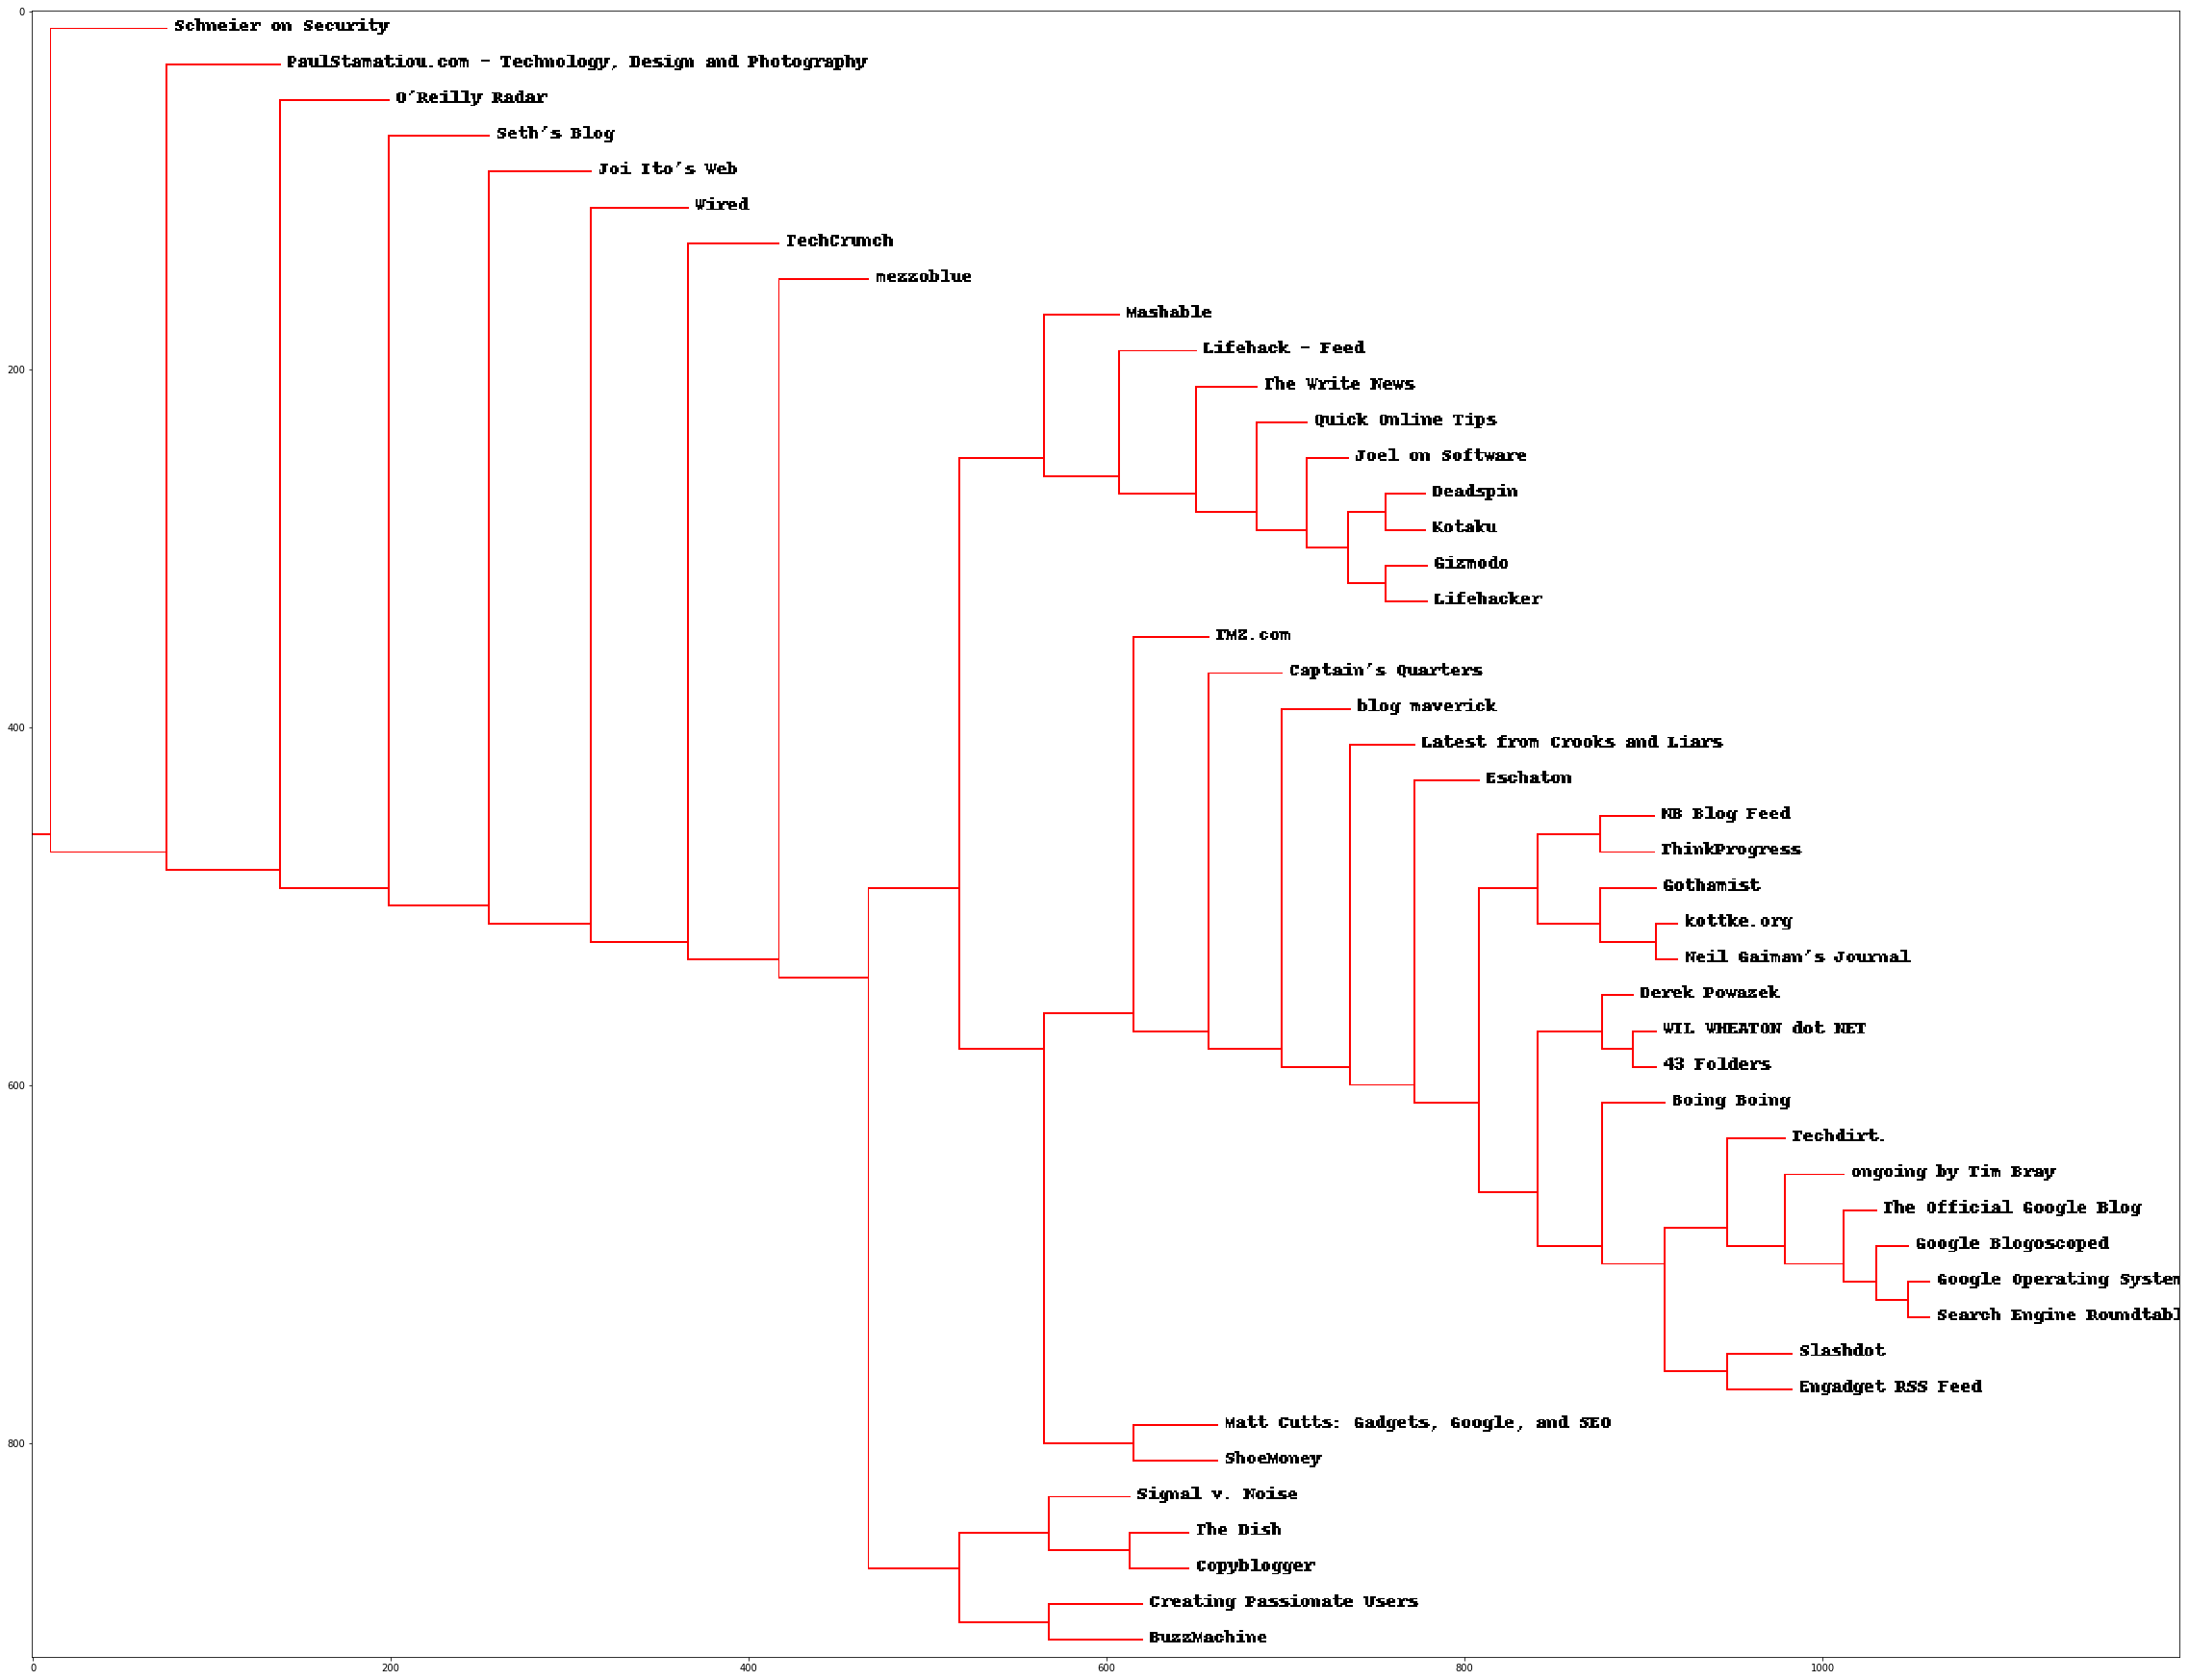

In [12]:
drawdendrogram(clust,rownames)

### 列聚类，对矩阵翻转

In [13]:
def rotatematrix(data):
    newdata = []
    for i in range(len(data[0])):
        newdata.append([row[i] for row in data])
    return newdata

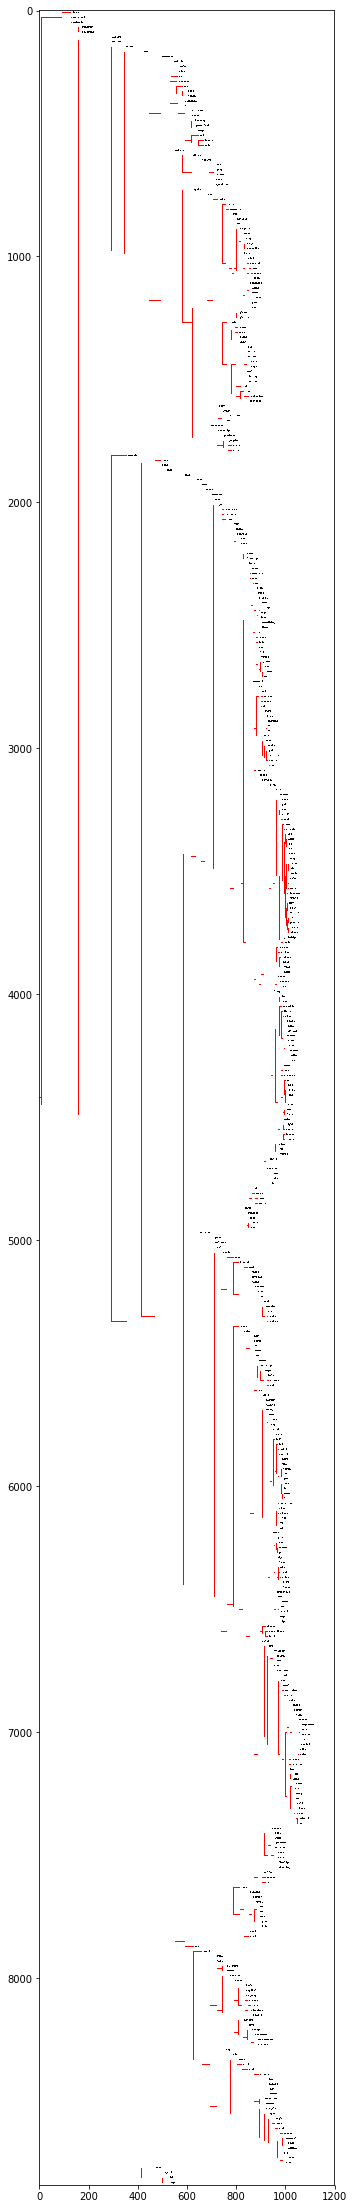

In [14]:
rdata = rotatematrix(data)
wordclust = hcluster(rdata)
drawdendrogram(wordclust,colnames)

### k-means

In [15]:
import random

def kcluster(data, distance=pearson, k=4):
    # 确定每一个特征的最大最小值
    ranges = [(min([row[i] for row in data]), max([row[i] for row in data])) for i in range(len(data[0]))]
    # 随机创建k个中心
    clusters = [[random.random()*(ranges[i][1]-ranges[i][0])+ranges[i][0]
                 for i in range(len(data[0]))] for j in range(k)]
    lastmatches = None
    for t in range(100):
        print('iteration %d'%t)
        # 归类
        bestmatches = [[] for i in range(k)]
        for i in range(len(data)):
            row = data[i]
            bestmatch = 0
            closest = distance(row, clusters[bestmatch])
            for j in range(k):
                d = distance(clusters[j], row)
                if d < closest:
                    closest = d
                    bestmatch = j
            bestmatches[bestmatch].append(i)
        # 更新中心值
        clusters = [[sum([data[idx][i] for idx in bestmatches[j]])/(len(bestmatches[j])+1e-8)
                     for i in range(len(data[0]))] for j in range(k)]
    return bestmatches

In [16]:
kclust = kcluster(data)

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49
iteration 50
iteration 51
iteration 52
iteration 53
iteration 54
iteration 55
iteration 56
iteration 57
iteration 58
iteration 59
iteration 60
iteration 61
iteration 62
iteration 63
iteration 64
iteration 65
iteration 66
iteration 67
iteration 68
iteration 69
iteration 70
iteration 71
iteration 72
iteration 73
iteration 74
iteration 75
iteration 76
iteration

In [17]:
[rownames[i] for i in kclust[0]]

['Eschaton',
 'Slashdot',
 'ThinkProgress',
 'BuzzMachine',
 "Captain's Quarters",
 'Engadget RSS Feed',
 'Schneier on Security',
 'TechCrunch',
 'Techdirt.',
 'Wired']

## 3. &nbsp; 对zebo网页进行聚类

### 下载数据集

In [18]:
!wget https://github.com/moneyDboat/Programming-Collective-Intelligence/raw/master/%E7%AC%AC03%E7%AB%A0%20%E5%8F%91%E7%8E%B0%E7%BE%A4%E7%BB%84/data/zebo.txt

wget: /opt/conda/lib/libuuid.so.1: no version information available (required by wget)
--2019-07-31 08:34:42--  https://github.com/moneyDboat/Programming-Collective-Intelligence/raw/master/%E7%AC%AC03%E7%AB%A0%20%E5%8F%91%E7%8E%B0%E7%BE%A4%E7%BB%84/data/zebo.txt
Resolving github.com (github.com)... 192.30.253.112
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/moneyDboat/Programming-Collective-Intelligence/master/%E7%AC%AC03%E7%AB%A0%20%E5%8F%91%E7%8E%B0%E7%BE%A4%E7%BB%84/data/zebo.txt [following]
--2019-07-31 08:34:42--  https://raw.githubusercontent.com/moneyDboat/Programming-Collective-Intelligence/master/%E7%AC%AC03%E7%AB%A0%20%E5%8F%91%E7%8E%B0%E7%BE%A4%E7%BB%84/data/zebo.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.1

### 只有 0，1值不适合 pearson，采用 Tanimoto
$$sim(x,y) = 1 - \frac{x \bigcap y}{x \bigcup y}$$

In [19]:
def tanimoto(x, y):
    c1, c2, shr = 0, 0, 0
    for i in range(len(x)):
        if x[i]:
            c1 += 1
        if y[i]:
            c2 += 1
        if x[i] and y[i]:
            shr += 1
    return 1 - float(shr) / (c1 + c2 - shr)

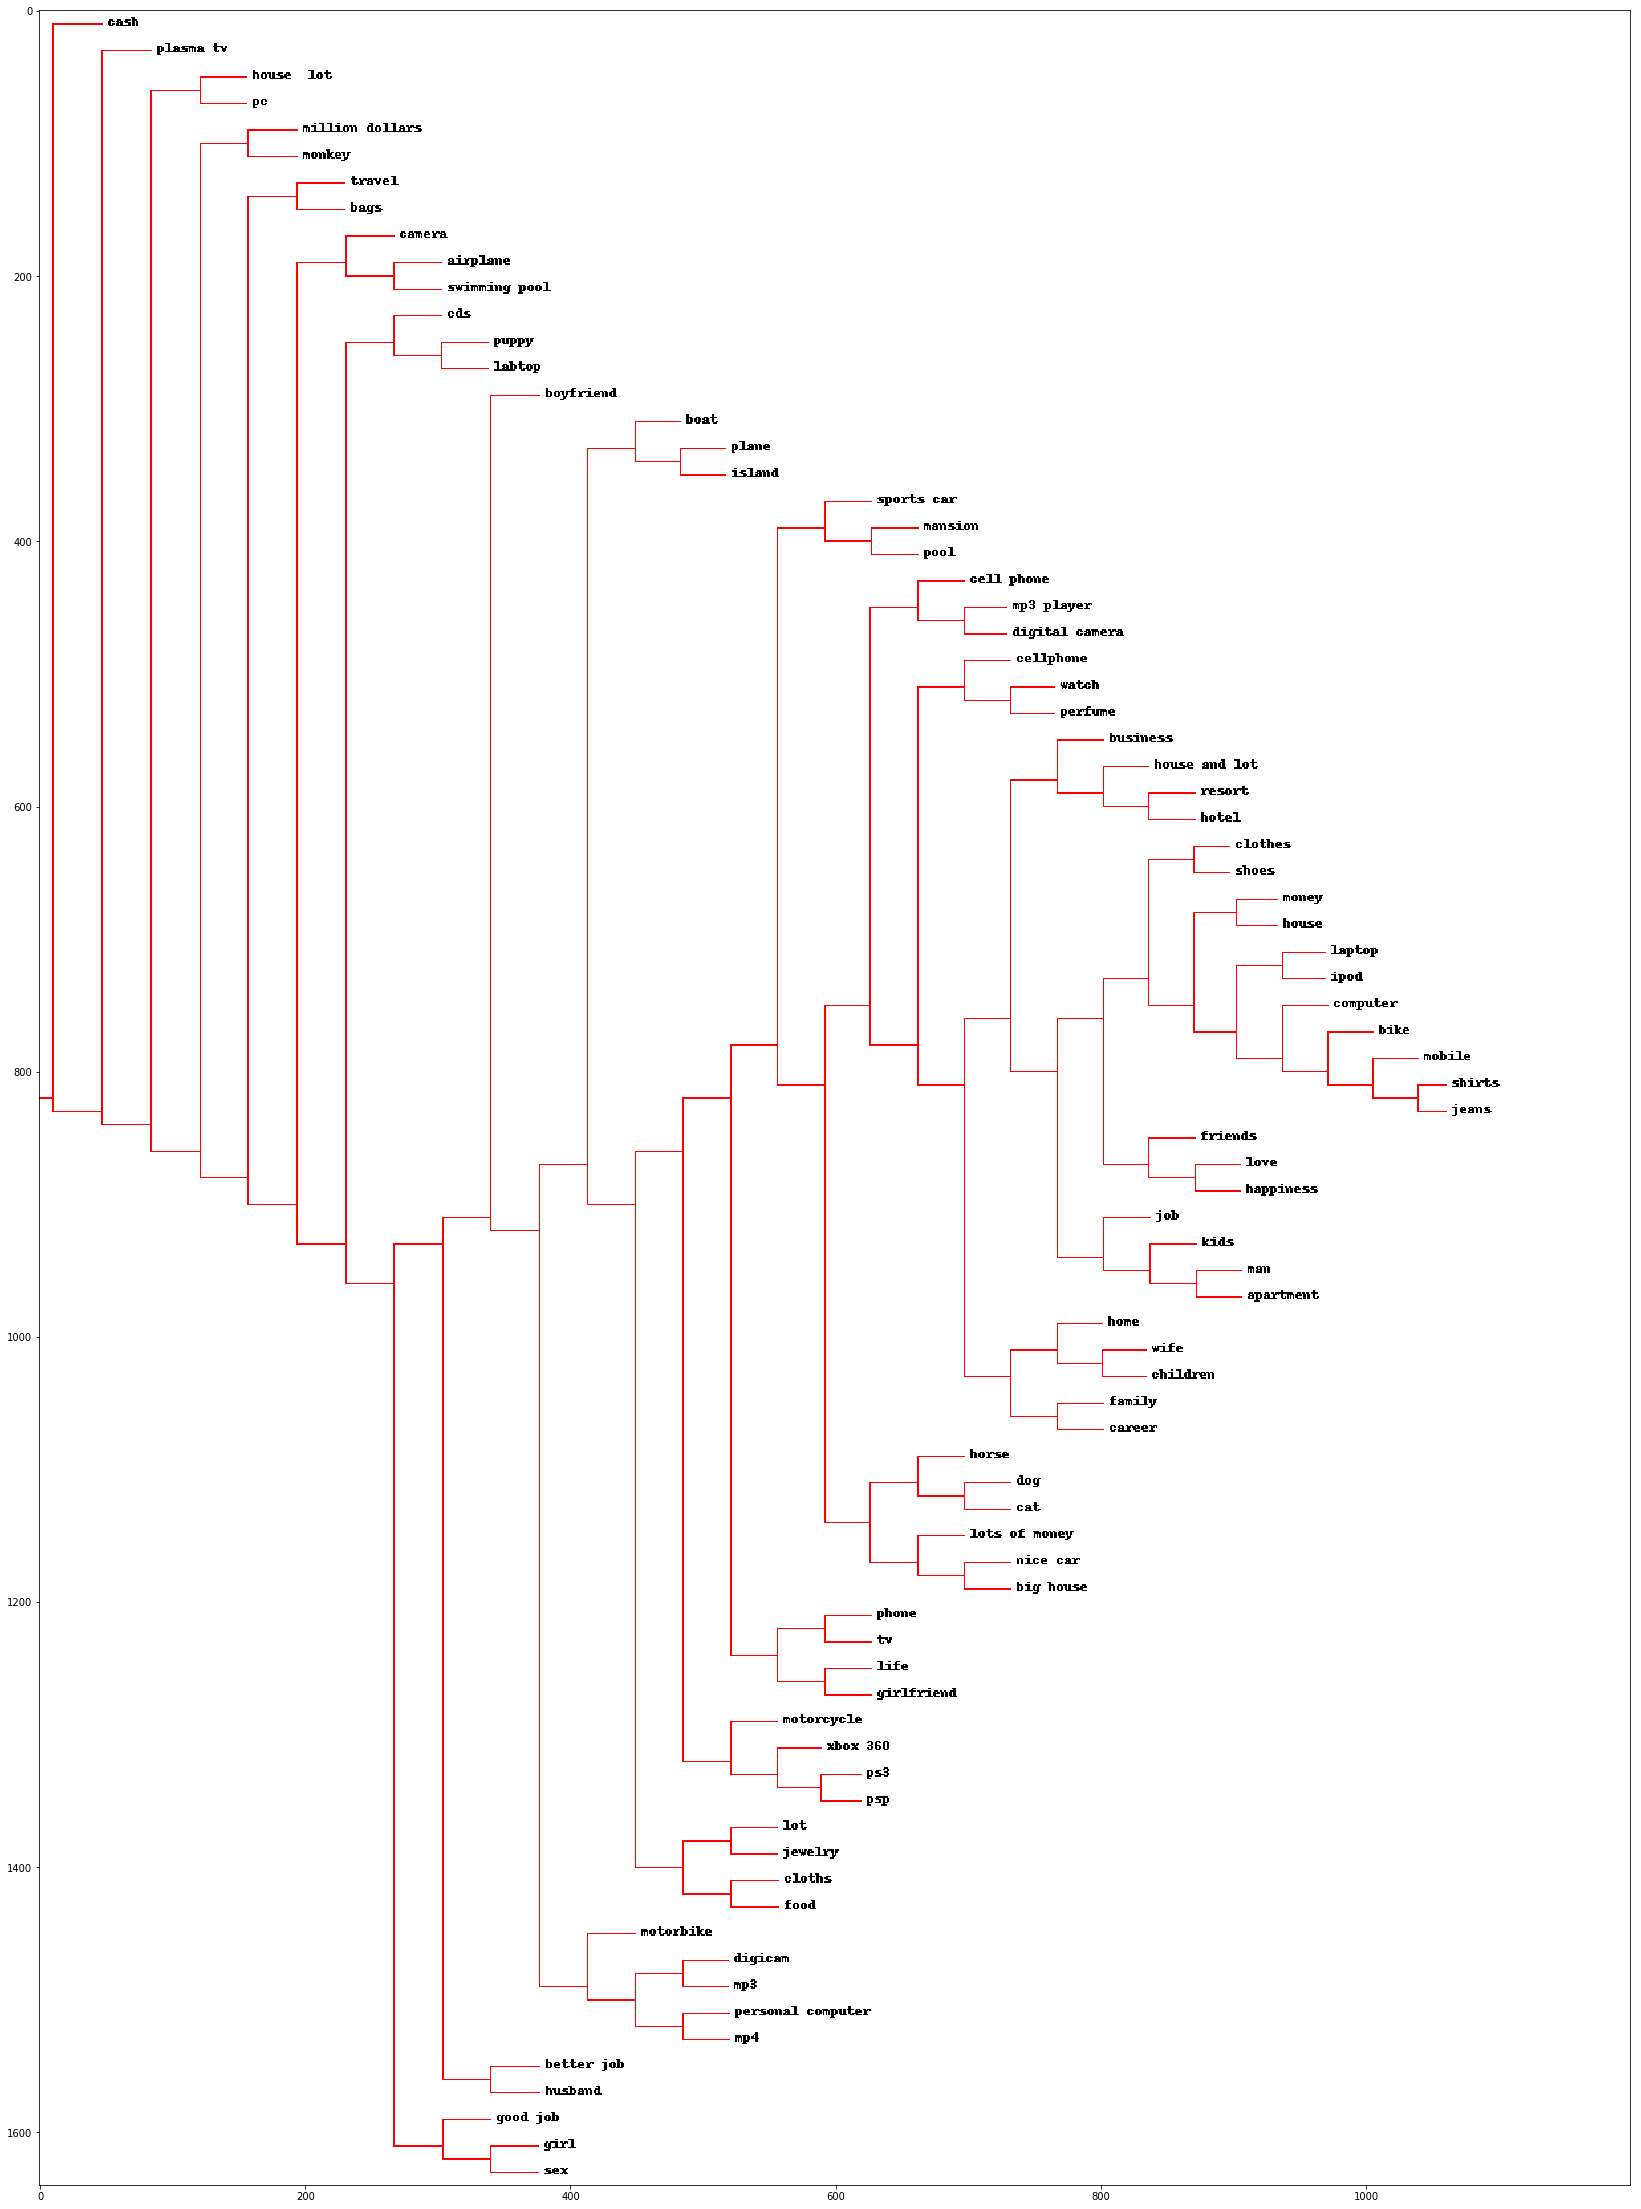

In [20]:
rownames, colnames, data = readDataSet('zebo.txt')
clust = hcluster(data, distance=tanimoto)
drawdendrogram(clust, rownames)

### 二维显示

In [21]:
def scaladown(data, distance=pearson, rate=0.01):
    n = len(data)
    realdist = [[0.0]*n for i in range(n)]
    for i in range(n):
        for j in range(i, n):
            realdist[i][j] = distance(data[i], data[j])
            realdist[j][i] = realdist[i][j]
    loc = [[random.random(), random.random()] for i in range(n)]
    fakedist = [[0.0]*n for i in range(n)]
    
    for t in range(1000):
        if t % 100 == 0:
            print('iteration %d' %t)
        for i in range(n):
            for j in range(i, n):
                fakedist[i][j] = sqrt(sum([(loc[i][k]-loc[j][k])**2 for k in range(len(loc[0]))]))
                fakedist[j][i] = fakedist[i][j]
        grad = [[0.0,0.0] for i in range(n)]
        for i in range(n):
            for j in range(n):
                if i==j:
                    continue
                error = (fakedist[i][j] - realdist[i][j]) / realdist[i][j]
                grad[i][0]+=((loc[i][0]-loc[j][0])/fakedist[i][j])*error
                grad[i][1]+=((loc[i][1]-loc[j][1])/fakedist[i][j])*error
            loc[i][0] -= rate*grad[i][0]
            loc[i][1] -= rate*grad[i][1]
    return loc

def draw2d(data,labels):
    img=Image.new('RGB',(2000,2000),(255,255,255))
    draw=ImageDraw.Draw(img)
    for i in range(len(data)):
        x=(data[i][0]+0.5)*1000
        y=(data[i][1]+0.5)*1000
        draw.text((x,y),labels[i],(0,0,0))
    plt.figure(figsize=(40,40))
#     plt.scatter(x,y,s=10)
    plt.imshow(img)

iteration 0
iteration 100
iteration 200
iteration 300
iteration 400
iteration 500
iteration 600
iteration 700
iteration 800
iteration 900


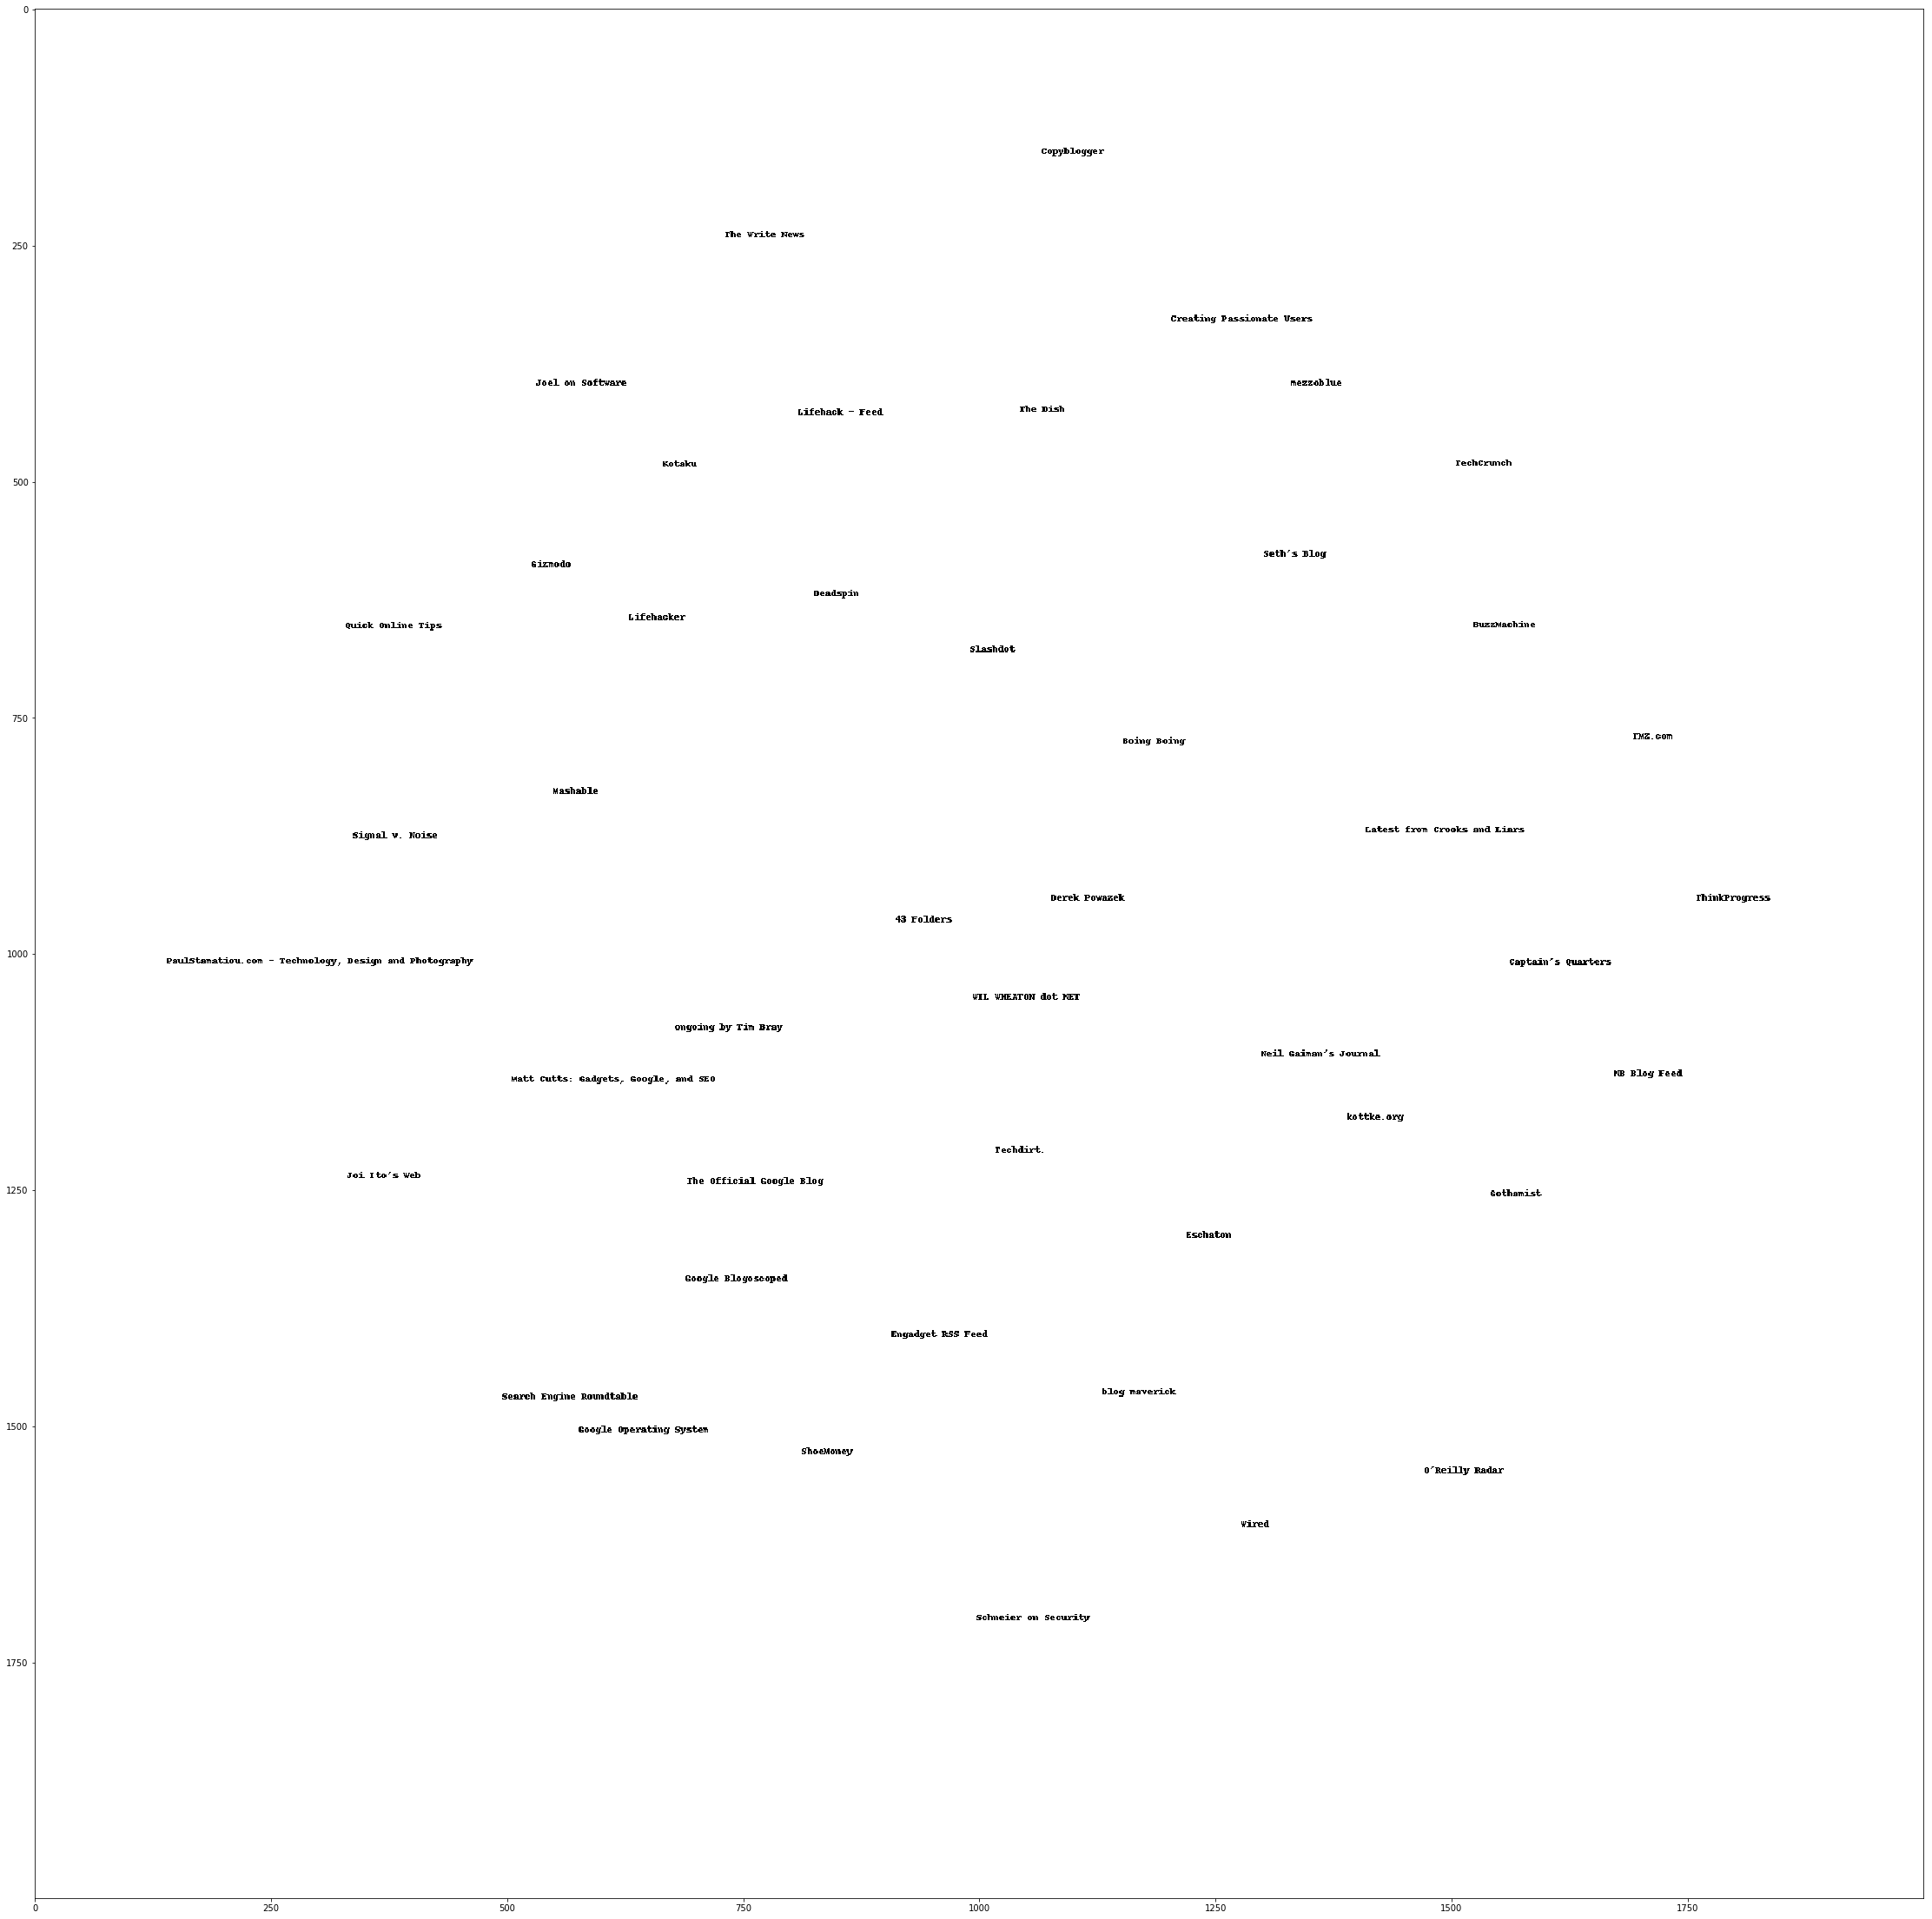

In [22]:
rownames, colnames, data = readDataSet('blogdata.txt')
loc = scaladown(data)
draw2d(loc, rownames)

## 4. &nbsp; 引用
[1] &nbsp; [集体智慧编程](https://book.douban.com/subject/3288908/)    
[2] &nbsp; [集体智慧编程笔记](https://github.com/moneyDboat/Programming-Collective-Intelligence)